# Myers-Briggs Personality Prediction

#### by Weston Shuken

---

## Overview

The purpose of this project is to take in typed text from a person and use machine learning algorithms to precict the personality type of that person. The personality type predictions are based on the Myers-Briggs Type Indicator (MBTI) test as the target variable. The features or predictor variables are comments and posts from users on [Reddit](https://www.reddit.com/) and [PersonalityCafe](https://www.personalitycafe.com/). These posts and comments come from users who have explicitley labeled their MBTI personality on their profile. 

The Myers-Briggs test is a very popular test that ask users approximately 90 questions about their behavior and assigns the user a type of personality based on this assessment. This test takes around 20-30 for someone to complete. 

There are 16 different personality types using a combination of 8 overall traits. See below:

    Introversion (I) vs Extroversion (E)
    Intuition (N) vs Sensing (S)
    Thinking (T) vs Feeling (F)
    Judging (J) vs Perceiving (P)
    

## Exploratory Data Analysis

In [137]:
# Imports for EDA, Cleaning, Plotting & Modeling
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import seaborn as sns
import re
import pickle

from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import plot_confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split, cross_val_score

from mbti import run_models

# Random Seed for everything
SEED = 53188535

In [2]:
# Loading the Data
cafe_df = pd.read_csv('data/mbti_1.csv')

In [3]:
mbti_lst = ['intp', 'intj', 'entp', 'entj', 'infj', 'infp', 'enfj', 'enfp', 'istj', 'isfj', 'estj', 'esfj', 'istp', 'isfp', 'estp', 'esfp']

In [4]:
cafe_df

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...
...,...,...
8670,ISFP,'https://www.youtube.com/watch?v=t8edHB_h908||...
8671,ENFP,'So...if this thread already exists someplace ...
8672,INTP,'So many questions when i do these things. I ...
8673,INFP,'I am very conflicted right now when it comes ...


In [5]:
cafe_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8675 entries, 0 to 8674
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   type    8675 non-null   object
 1   posts   8675 non-null   object
dtypes: object(2)
memory usage: 135.7+ KB


In [6]:
cafe_df['type'].value_counts()

INFP    1832
INFJ    1470
INTP    1304
INTJ    1091
ENTP     685
ENFP     675
ISTP     337
ISFP     271
ENTJ     231
ISTJ     205
ENFJ     190
ISFJ     166
ESTP      89
ESFP      48
ESFJ      42
ESTJ      39
Name: type, dtype: int64

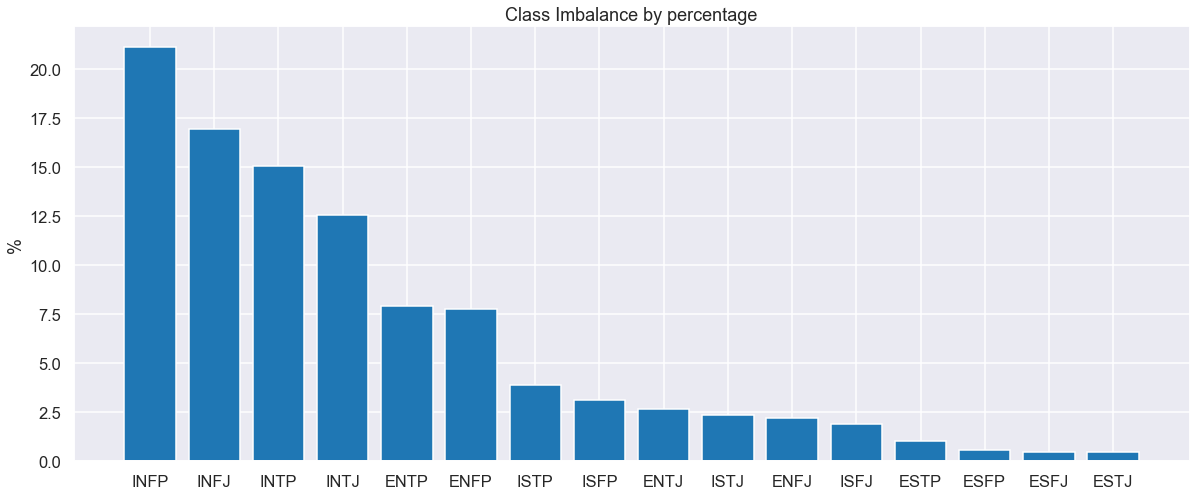

In [7]:
sns.set_context('talk')
sns.set_style('darkgrid')
plt.figure(figsize=(20,8))
plt.bar(cafe_df['type'].value_counts(normalize=True).index, cafe_df['type'].value_counts(normalize=True).values*100)
plt.title('Class Imbalance by percentage')
plt.ylabel('%');

In [8]:
# looking at 2 some random posts
rint = np.random.randint(0, len(cafe_df))
print('>'*10 + cafe_df['type'].iloc[rint] + '<'*10)
print('-'*25)
print(cafe_df['posts'].iloc[rint][:1000])

## BE CAREFUL... Reddit posts can often be quite rude...

>>>>>>>>>>INTP<<<<<<<<<<
-------------------------
'I've always thought the League champions to not have enough background depth to really get a good judgment on a personality type, but there are a few that stand out.  Draven - ESTP,  Type 3 on the...|||You are a: Left-Leaning Anarchist Isolationist Humanist LibertineCollectivism score: 17% Authoritarianism score: -83% Internationalism score: -50% Tribalism score: -67% Liberalism score: 100% ...|||Does anyone here play Drawception?  I find it to be rather entertaining, especially seeing what a simple concept can transform into.    Drawception - The social picture telephone game!  My...|||That's something that always interested me too.  I'll play any role, but I prefer top lane and sometimes support.  My favorite champions tend to be those who can win teamfights or splitpush easily...|||I like being the center of attention if I'm showing off some idea, something I've made, or in the case of doing well in a competition and drawing a crow

#### Takeaways from seeing the dataset:

- The classes are quite imbalanced, which can bias the model to choosing one class over the other just given class weight.
- There is a lot of cleaning to do with the text (lowercase, remove urls, remove symbols/punctuation, lemmitization, etc.)
- There are definitely incorrect spellings of words and acroynms like `lol` & `btw`
- The posts might include the personality type in them, which could be considered `data leakage`.

### Cleaning & Tokenizing

In [9]:
cafe_clean = cafe_df.copy()

In [10]:
# Lowercase y variables
cafe_clean['type'] = cafe_clean.type.str.lower()

# Lowercase X varaible onto a new column
cafe_clean['clean_posts'] = cafe_clean['posts'].str.lower()

In [11]:
def url_remove(post):
    return re.sub(r'http\S+', '', post)

def pipe_remove(post):
    return re.sub(r'[|]', ' ', post)

def punc_remove(post):
    return re.sub(r'[\'_:]', '', post)

def remove_dig_token(post):
    return [post[i] for i in range(len(post)) if post[i].isalpha()]

def remove_stopwords(post):
    sw = stopwords.words('english')
    # sw.extend(mbti_lst)
    return [post[i] for i in range(len(post)) if post[i] not in sw]

regxx = '(intp)|(intj)|(entp)|(entj)|(infj)|(infp)|(enfj)|(enfp)|(istj)|(isfj)|(estj)|(esfj)|(istp)|(isfp)|(estp)|(esfp)'
def replace_mbti(post):
    new = re.sub("r" + regxx, "", post)
    return new

In [12]:
cafe_clean['clean_posts'] = cafe_clean['clean_posts'].apply(replace_mbti)

In [13]:
# The posts contain multiple posts seperated by 3 pipes '|||' w/ no spaces between. 
# This function will remove pipes and replace with a space.
cafe_clean['clean_posts'] = cafe_clean['clean_posts'].apply(pipe_remove)

In [14]:
# This funciton will remove URLs in the posts
cafe_clean['clean_posts'] = cafe_clean['clean_posts'].apply(url_remove)

In [15]:
# This function will remove punctuation (dependent on what is passed in). This has `/``, `_`, `:` 
cafe_clean['clean_posts'] = cafe_clean['clean_posts'].apply(punc_remove)

In [16]:
# This will create a column of cleaned words that have been tokenized.

pattern = r"(?u)\b\w\w+\b" # words with more than 2 letters

tokenizer = RegexpTokenizer(pattern) # instantiate tokenizer

cafe_clean['post_tokens'] = cafe_clean['clean_posts'].apply(tokenizer.tokenize)

In [17]:
# Removing any remaining numeric digits
cafe_clean['post_tokens'] = cafe_clean['post_tokens'].apply(remove_dig_token)

In [18]:
# Removing stopwords
cafe_clean['post_tokens'] = cafe_clean['post_tokens'].apply(remove_stopwords)

In [19]:
# Lemmatizing the words
lemmatizer = WordNetLemmatizer()

def lemmatize_text(tokens):
    return [lemmatizer.lemmatize(w) for w in tokens]

cafe_clean['post_tokens'] = cafe_clean['post_tokens'].apply(lemmatize_text)

In [20]:
# Joining the tokens together into one long string
def join_tokens(tokens):
    long_string = ' '.join(tokens)
    return long_string

cafe_clean['joined_tokens'] = cafe_clean['post_tokens'].apply(join_tokens) # Creating new column

In [21]:
cafe_clean

,type,posts,clean_posts,post_tokens,joined_tokens
0,infj,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,and moments sportscenter not top te...,"[moment, sportscenter, top, ten, play, prank, ...",moment sportscenter top ten play prank life ch...
1,entp,'I'm finding the lack of me in these posts ver...,im finding the lack of me in these posts very ...,"[im, finding, lack, post, alarming, sex, borin...",im finding lack post alarming sex boring posit...
2,intp,'Good one _____ https://www.youtube.com/wat...,"good one of course, to which i say i kn...","[good, one, course, say, know, thats, blessing...",good one course say know thats blessing curse ...
3,intj,"'Dear INTP, I enjoyed our conversation the o...","dear intp, i enjoyed our conversation the ot...","[dear, intp, enjoyed, conversation, day, esote...",dear intp enjoyed conversation day esoteric ga...
4,entj,'You're fired.|||That's another silly misconce...,youre fired. thats another silly misconcepti...,"[youre, fired, thats, another, silly, misconce...",youre fired thats another silly misconception ...
...,...,...,...,...,...
8670,isfp,'https://www.youtube.com/watch?v=t8edHB_h908||...,ixfp just because i always think of cats as...,"[ixfp, always, think, cat, fi, doms, reason, e...",ixfp always think cat fi doms reason especiall...
8671,enfp,'So...if this thread already exists someplace ...,so...if this thread already exists someplace e...,"[thread, already, exists, someplace, else, hec...",thread already exists someplace else heck dele...
8672,intp,'So many questions when i do these things. I ...,so many questions when i do these things. i w...,"[many, question, thing, would, take, purple, p...",many question thing would take purple pill pic...
8673,infp,'I am very conflicted right now when it comes ...,i am very conflicted right now when it comes t...,"[conflicted, right, come, wanting, child, hone...",conflicted right come wanting child honestly m...


The pre-cleaned tokens tally up to 10637645 total words
The cleaned tokens tally up to 5390281 total words
--------------------
Each feature in pre-cleaned has on average 1226.0 words
Each feature in cleaned has on average 621.0 words
--------------------
Each feature in pre-cleaned  has a median of 1278.0 words
Each feature has a median of 647.0 words
--------------------
The minimum post in pre-cleaned  is 4 words
The minimum post in cleaned is 0 words
--------------------
The minimum post in pre-cleaned  is 1881 words
The minimum post in cleaned is 918 words
--------------------


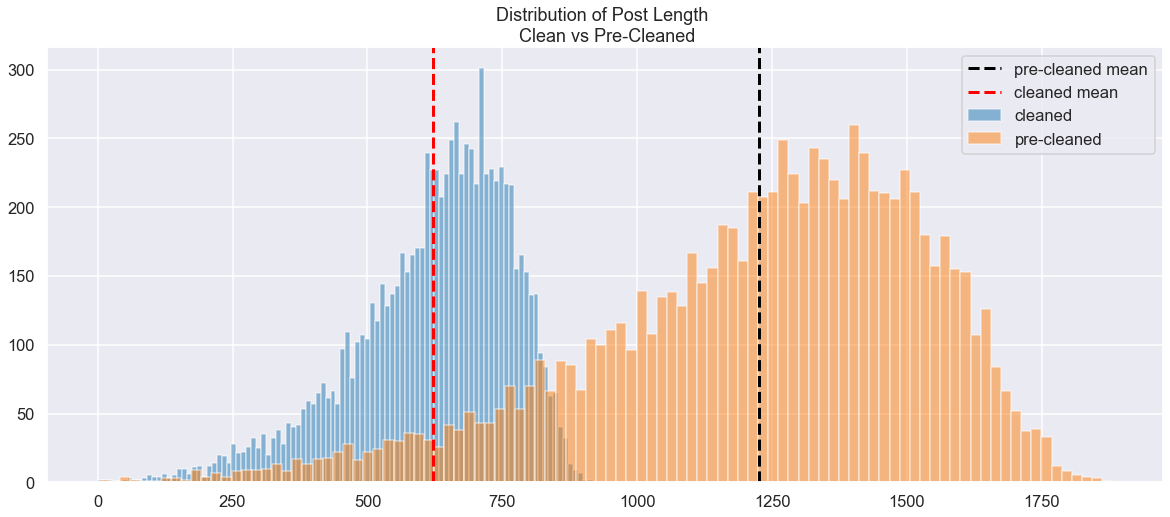

In [22]:
total_words = cafe_clean['posts'].apply(lambda x: len(x.split())).sum()
print(f'The pre-cleaned tokens tally up to {total_words} total words')

clean_words = cafe_clean['post_tokens'].apply(lambda x: len(x)).sum()
print(f'The cleaned tokens tally up to {clean_words} total words')

print('-'*20)

ave_post = cafe_clean['posts'].apply(lambda x: len(x.split())).mean()
print(f'Each feature in pre-cleaned has on average {round(ave_post)} words')

ave_cleaned = cafe_clean['post_tokens'].apply(lambda x: len(x)).mean()
print(f'Each feature in cleaned has on average {round(ave_cleaned)} words')

print('-'*20)

med_post = cafe_clean['posts'].apply(lambda x: len(x.split())).median()
print(f'Each feature in pre-cleaned  has a median of {round(med_post)} words')

med_cleaned = cafe_clean['post_tokens'].apply(lambda x: len(x)).median()
print(f'Each feature has a median of {round(med_cleaned)} words')

print('-'*20)

min_post = cafe_clean['posts'].apply(lambda x: len(x.split())).min()
print(f'The minimum post in pre-cleaned  is {round(min_post)} words')

min_cleaned = cafe_clean['post_tokens'].apply(lambda x: len(x)).min()
print(f'The minimum post in cleaned is {round(min_cleaned)} words')

print('-'*20)

max_post = cafe_clean['posts'].apply(lambda x: len(x.split())).max()
print(f'The minimum post in pre-cleaned  is {round(max_post)} words')

max_cleaned = cafe_clean['post_tokens'].apply(lambda x: len(x)).max()
print(f'The minimum post in cleaned is {round(max_cleaned)} words')

print('-'*20)

plt.figure(figsize=(20,8))
plt.hist(cafe_clean['post_tokens'].apply(lambda x: len(x)), label='cleaned', alpha=.5, bins=100)
plt.hist(cafe_clean['posts'].apply(lambda x: len(x.split())), label='pre-cleaned', alpha=.5, bins=100)
plt.axvline(ave_post, color='k', linestyle='dashed', linewidth=3, label='pre-cleaned mean')
plt.axvline(ave_cleaned, color='r', linestyle='dashed', linewidth=3, label='cleaned mean')
plt.legend()
plt.title('Distribution of Post Length \n Clean vs Pre-Cleaned');

In [23]:
rint = np.random.randint(0, len(cafe_df))
print('>'*10 + cafe_df['type'].iloc[rint] + '<'*10)
print('-'*25)
print(cafe_clean['posts'].iloc[rint][:1000])
print('-'*25)
print(cafe_clean['joined_tokens'].iloc[rint][:1000])

>>>>>>>>>>INTP<<<<<<<<<<
-------------------------
Interesting, might be unrelated but I just happened to be watching a documentary BBC iPlayer - Horizon: 2011-2012: Do You See What I See? last night about colour. While I had read about it before it...|||You could always take a playboy (or equivalent) in with you and do a handstand. Of course you only have small time window with which to accomplish your task.|||Here's a simple conversation that will help you socialise.  You: I was reading about this tricky problem and I'm stuck with it. Him: What problem is that. You: (Describe some difficult problem...|||What evidence do you have to support that statement?|||But isn't your concept of God based on what is outlined in a book written by man (who can lie).|||Two that come to mind are Valhalla Rising, Crazy Eights.|||In work I do some computer modelling of various systems so having extra variety in the languages you know can allow you to speed up certain applications. Also if the uni I wen

#### Takeaways:
- A lot of words were reduced or eliminated that did not provide any use.
- The dataset still has posts with very little words. Might need to drop these.
- The lemmitization did not work well on some verbs and the `MBTI` replacement often is followed by an `s`.


In [24]:
# Adding Binary Targets
cafe_clean['i/e'] = cafe_clean['type'].map(lambda x: x[0])
cafe_clean['n/s'] = cafe_clean['type'].map(lambda x: x[1])
cafe_clean['t/f'] = cafe_clean['type'].map(lambda x: x[2])
cafe_clean['p/j'] = cafe_clean['type'].map(lambda x: x[3])


In [25]:
print(cafe_clean['i/e'].value_counts())
print(cafe_clean['n/s'].value_counts())
print(cafe_clean['t/f'].value_counts())
print(cafe_clean['p/j'].value_counts())

i    6676
e    1999
Name: i/e, dtype: int64
n    7478
s    1197
Name: n/s, dtype: int64
f    4694
t    3981
Name: t/f, dtype: int64
p    5241
j    3434
Name: p/j, dtype: int64


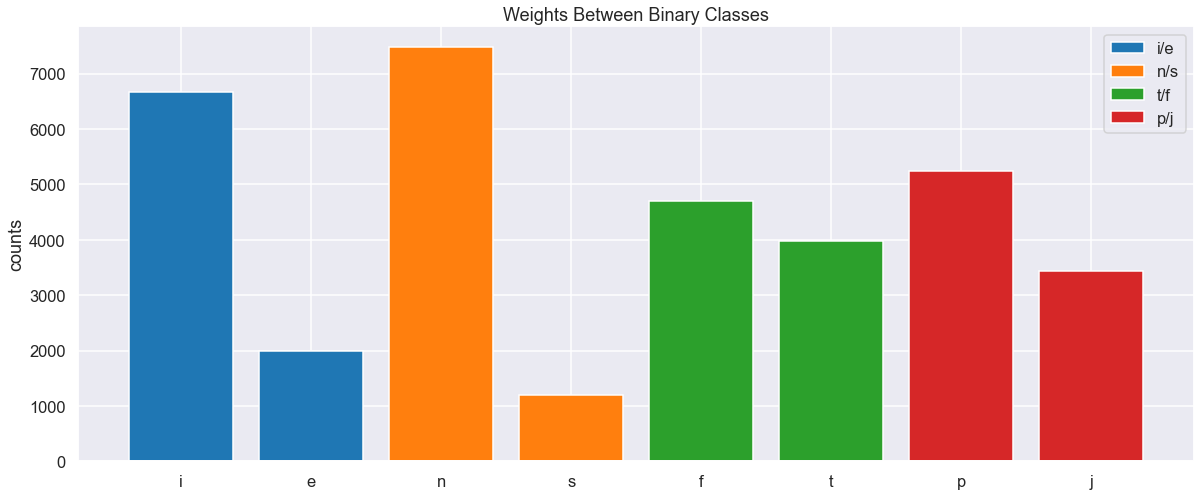

In [26]:
plt.figure(figsize=(20,8))
plt.title('Weights Between Binary Classes')
plt.ylabel('counts')
for column in cafe_clean.columns[-4:]:
    plt.bar(cafe_clean[column].value_counts().index, cafe_clean[column].value_counts().values, label=column)

plt.legend()
plt.show();

## Modeling

There will be 4 sections of modeling:

1. Multiclass
2. Multiclass balanced classes using undersampling
3. Binary
4. Binary balanced classes using undersampling

In [27]:
# Baseline

baseline_models = {'SGDClassifier': SGDClassifier(class_weight='balanced', random_state=SEED),

                #   'LogisticRegression': LogisticRegression(max_iter=1000, solver='saga'),

                  'NaiveBayes': MultinomialNB()
               
                #   'DecisionTree': DecisionTreeClassifier(random_state=SEED),
               
                #   'RandomForest': RandomForestClassifier(random_state=SEED)
               }

In [28]:
for clf in baseline_models:
    print(baseline_models[clf])

SGDClassifier(class_weight='balanced', random_state=53188535)
MultinomialNB()


In [29]:
print(cafe_clean['i/e'].value_counts(normalize=True))
print(cafe_clean['n/s'].value_counts(normalize=True))
print(cafe_clean['t/f'].value_counts(normalize=True))
print(cafe_clean['p/j'].value_counts(normalize=True))

i    0.769568
e    0.230432
Name: i/e, dtype: float64
n    0.862017
s    0.137983
Name: n/s, dtype: float64
f    0.541095
t    0.458905
Name: t/f, dtype: float64
p    0.60415
j    0.39585
Name: p/j, dtype: float64


In [30]:
models_table = pd.DataFrame(columns=['Model', 'Target', 'CVScore', 'TestAcc'])

In [31]:
rm = run_models()

In [32]:
bin_targets = cafe_clean.columns[-4:]

In [33]:
rm.run(cafe_clean, 'joined_tokens', bin_targets, baseline_models, models_table, tfidf=True, SEED=234)

--------------------
Vectorizing....  @ Fri Feb 25 15:04:20 2022
Working on SGDClassifier for i/e @ Fri Feb 25 15:04:34 2022
Working on NaiveBayes for i/e @ Fri Feb 25 15:04:37 2022
--------------------
Vectorizing....  @ Fri Feb 25 15:04:38 2022
Working on SGDClassifier for n/s @ Fri Feb 25 15:04:51 2022
Working on NaiveBayes for n/s @ Fri Feb 25 15:04:53 2022
--------------------
Vectorizing....  @ Fri Feb 25 15:04:53 2022
Working on SGDClassifier for t/f @ Fri Feb 25 15:05:07 2022
Working on NaiveBayes for t/f @ Fri Feb 25 15:05:10 2022
--------------------
Vectorizing....  @ Fri Feb 25 15:05:11 2022
Working on SGDClassifier for p/j @ Fri Feb 25 15:05:24 2022
Working on NaiveBayes for p/j @ Fri Feb 25 15:05:28 2022


,Model,Target,CVScore,TestAcc
0,SGDClassifier_i/e,i/e,0.7819,0.7875
1,NaiveBayes_i/e,i/e,0.7704,0.7672
2,SGDClassifier_n/s,n/s,0.8644,0.8585
3,NaiveBayes_n/s,n/s,0.8644,0.8548
4,SGDClassifier_t/f,t/f,0.8086,0.8036
5,NaiveBayes_t/f,t/f,0.5458,0.5284
6,SGDClassifier_p/j,p/j,0.6935,0.6985
7,NaiveBayes_p/j,p/j,0.6101,0.5864


In [34]:
rm.run(cafe_clean, 'joined_tokens', bin_targets, baseline_models, models_table, tfidf=False, SEED=234)

--------------------
Vectorizing....  @ Fri Feb 25 15:05:29 2022
Working on SGDClassifier for i/e @ Fri Feb 25 15:05:42 2022
Working on NaiveBayes for i/e @ Fri Feb 25 15:05:45 2022
--------------------
Vectorizing....  @ Fri Feb 25 15:05:46 2022
Working on SGDClassifier for n/s @ Fri Feb 25 15:05:59 2022
Working on NaiveBayes for n/s @ Fri Feb 25 15:06:02 2022
--------------------
Vectorizing....  @ Fri Feb 25 15:06:03 2022
Working on SGDClassifier for t/f @ Fri Feb 25 15:06:16 2022
Working on NaiveBayes for t/f @ Fri Feb 25 15:06:19 2022
--------------------
Vectorizing....  @ Fri Feb 25 15:06:20 2022
Working on SGDClassifier for p/j @ Fri Feb 25 15:06:33 2022
Working on NaiveBayes for p/j @ Fri Feb 25 15:06:36 2022


,Model,Target,CVScore,TestAcc
0,SGDClassifier_i/e,i/e,0.7737,0.7658
1,NaiveBayes_i/e,i/e,0.7690,0.7672
2,SGDClassifier_n/s,n/s,0.8457,0.8345
3,NaiveBayes_n/s,n/s,0.8640,0.8548
4,SGDClassifier_t/f,t/f,0.7847,0.7792
5,NaiveBayes_t/f,t/f,0.6997,0.6201
6,SGDClassifier_p/j,p/j,0.6729,0.6676
7,NaiveBayes_p/j,p/j,0.6211,0.5869


In [35]:
rm.run_usampled(cafe_clean, 'joined_tokens', bin_targets, baseline_models, models_table, tfidf=False, SEED=234)

(array(['e', 'i'], dtype=object), array([1494, 5012]))
(array(['e', 'i'], dtype=object), array([1494, 1494]))
Vectorizing....  @ Fri Feb 25 15:06:37 2022
Working on SGDClassifier @ Fri Feb 25 15:06:44 2022
Working on NaiveBayes @ Fri Feb 25 15:06:45 2022
(array(['n', 's'], dtype=object), array([5624,  882]))
(array(['n', 's'], dtype=object), array([882, 882]))
Vectorizing....  @ Fri Feb 25 15:06:46 2022
Working on SGDClassifier @ Fri Feb 25 15:06:51 2022
Working on NaiveBayes @ Fri Feb 25 15:06:51 2022
(array(['f', 't'], dtype=object), array([3547, 2959]))
(array(['f', 't'], dtype=object), array([2959, 2959]))
Vectorizing....  @ Fri Feb 25 15:06:51 2022
Working on SGDClassifier @ Fri Feb 25 15:07:04 2022
Working on NaiveBayes @ Fri Feb 25 15:07:07 2022
(array(['j', 'p'], dtype=object), array([2537, 3969]))
(array(['j', 'p'], dtype=object), array([2537, 2537]))
Vectorizing....  @ Fri Feb 25 15:07:07 2022
Working on SGDClassifier @ Fri Feb 25 15:07:19 2022
Working on NaiveBayes @ Fri Feb

,Model,Target,CVScore,TestAcc
0,SGDClassifier_i/e,i/e,0.6653,0.6690
1,NaiveBayes_i/e,i/e,0.6734,0.6565
2,SGDClassifier_n/s,n/s,0.6661,0.6339
3,NaiveBayes_n/s,n/s,0.7063,0.7243
4,SGDClassifier_t/f,t/f,0.7705,0.7828
5,NaiveBayes_t/f,t/f,0.7492,0.7506
6,SGDClassifier_p/j,p/j,0.6529,0.6551
7,NaiveBayes_p/j,p/j,0.6569,0.6657


In [36]:
rm.run_usampled(cafe_clean, 'joined_tokens', bin_targets, baseline_models, models_table, tfidf=True, SEED=234)

(array(['e', 'i'], dtype=object), array([1494, 5012]))
(array(['e', 'i'], dtype=object), array([1494, 1494]))
Vectorizing....  @ Fri Feb 25 15:07:22 2022
Working on SGDClassifier @ Fri Feb 25 15:07:30 2022
Working on NaiveBayes @ Fri Feb 25 15:07:31 2022
(array(['n', 's'], dtype=object), array([5624,  882]))
(array(['n', 's'], dtype=object), array([882, 882]))
Vectorizing....  @ Fri Feb 25 15:07:31 2022
Working on SGDClassifier @ Fri Feb 25 15:07:36 2022
Working on NaiveBayes @ Fri Feb 25 15:07:36 2022
(array(['f', 't'], dtype=object), array([3547, 2959]))
(array(['f', 't'], dtype=object), array([2959, 2959]))
Vectorizing....  @ Fri Feb 25 15:07:37 2022
Working on SGDClassifier @ Fri Feb 25 15:07:49 2022
Working on NaiveBayes @ Fri Feb 25 15:07:52 2022
(array(['j', 'p'], dtype=object), array([2537, 3969]))
(array(['j', 'p'], dtype=object), array([2537, 2537]))
Vectorizing....  @ Fri Feb 25 15:07:52 2022
Working on SGDClassifier @ Fri Feb 25 15:08:04 2022
Working on NaiveBayes @ Fri Feb

,Model,Target,CVScore,TestAcc
0,SGDClassifier_i/e,i/e,0.7115,0.6879
1,NaiveBayes_i/e,i/e,0.6897,0.5892
2,SGDClassifier_n/s,n/s,0.7097,0.7225
3,NaiveBayes_n/s,n/s,0.7137,0.7612
4,SGDClassifier_t/f,t/f,0.8091,0.8082
5,NaiveBayes_t/f,t/f,0.7170,0.7243
6,SGDClassifier_p/j,p/j,0.6882,0.6893
7,NaiveBayes_p/j,p/j,0.6612,0.6639


---

## Model Tuning

In [70]:
final_model = Pipeline([('vec', TfidfVectorizer(ngram_range=(1,2))),
    ('clf', SGDClassifier(class_weight='balanced', random_state=SEED))
])

              precision    recall  f1-score   support

           i       0.64      0.26      0.37       458
           e       0.83      0.96      0.89      1711

    accuracy                           0.81      2169
   macro avg       0.74      0.61      0.63      2169
weighted avg       0.79      0.81      0.78      2169

              precision    recall  f1-score   support

           n       0.87      0.99      0.93      1877
           s       0.47      0.03      0.06       292

    accuracy                           0.86      2169
   macro avg       0.67      0.51      0.49      2169
weighted avg       0.82      0.86      0.81      2169

              precision    recall  f1-score   support

           f       0.80      0.86      0.83      1150
           t       0.83      0.75      0.79      1019

    accuracy                           0.81      2169
   macro avg       0.81      0.81      0.81      2169
weighted avg       0.81      0.81      0.81      2169

              preci

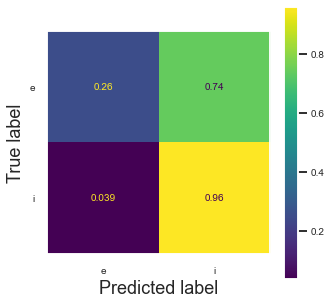

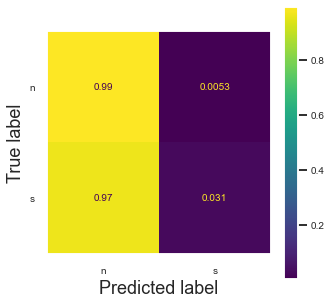

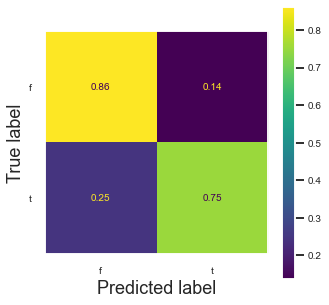

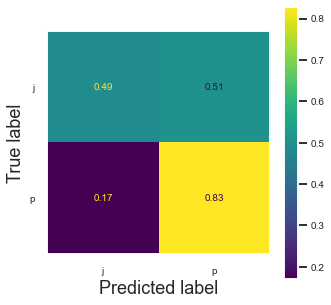

In [71]:
for target in bin_targets:
    X = cafe_clean['joined_tokens']
    y = cafe_clean[target]

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)

    final_model.fit(X_train, y_train)

    y_pred = final_model.predict(X_test)
    acc_score = accuracy_score(y_pred, y_test)

    print(classification_report(y_pred=y_pred, y_true=y_test, target_names=cafe_clean[target].unique()))

    fig, ax = plt.subplots(figsize=(5,5))
    plt.rcParams.update({'font.size': 10})
    plt.rc('xtick', labelsize=10) 
    plt.rc('ytick', labelsize=10) 
    plot_confusion_matrix(final_model, X_test, y_test, ax=ax, normalize='true')
    plt.grid(False);
    

---

### i/e

In [60]:
cafe_clean['i/e'].value_counts(normalize=True)

i    0.769568
e    0.230432
Name: i/e, dtype: float64

              precision    recall  f1-score   support

           i       0.47      0.53      0.50       458
           e       0.87      0.84      0.86      1711

    accuracy                           0.78      2169
   macro avg       0.67      0.69      0.68      2169
weighted avg       0.79      0.78      0.78      2169



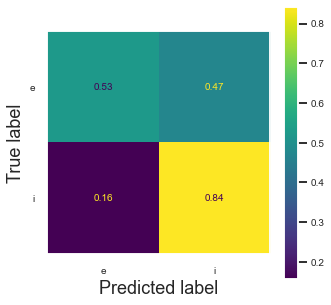

In [62]:
sgd_t = Pipeline([('vec', TfidfVectorizer(ngram_range=(1,2))),
                ('clf', SGDClassifier(class_weight={'e': .77, 'i': .23}, random_state=SEED))
            ])

X = cafe_clean['joined_tokens']
y = cafe_clean['i/e']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)

sgd_t.fit(X_train, y_train)

y_pred = sgd_t.predict(X_test)
acc_score = accuracy_score(y_pred, y_test)
print(classification_report(y_pred=y_pred, y_true=y_test, target_names=cafe_clean['i/e'].unique()))

fig, ax = plt.subplots(figsize=(5,5))
plt.rcParams.update({'font.size': 10})
plt.rc('xtick', labelsize=10) 
plt.rc('ytick', labelsize=10) 
plot_confusion_matrix(sgd_t, X_test, y_test, ax=ax, normalize='true')
plt.grid(False);

---

### n/s

In [63]:
cafe_clean['n/s'].value_counts(normalize=True)

n    0.862017
s    0.137983
Name: n/s, dtype: float64

              precision    recall  f1-score   support

           n       0.93      0.79      0.85      1877
           s       0.31      0.62      0.41       292

    accuracy                           0.76      2169
   macro avg       0.62      0.70      0.63      2169
weighted avg       0.85      0.76      0.79      2169



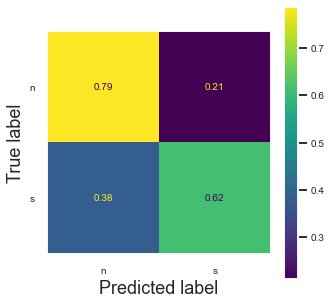

In [66]:
sgd_t = Pipeline([('vec', TfidfVectorizer(ngram_range=(1,2))),
                ('clf', SGDClassifier(class_weight={'s': .90, 'n': .10}, random_state=SEED))
            ])

X = cafe_clean['joined_tokens']
y = cafe_clean['n/s']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)

sgd_t.fit(X_train, y_train)

y_pred = sgd_t.predict(X_test)
acc_score = accuracy_score(y_pred, y_test)
print(classification_report(y_pred=y_pred, y_true=y_test, target_names=cafe_clean['n/s'].unique()))

fig, ax = plt.subplots(figsize=(5,5))
plt.rcParams.update({'font.size': 10})
plt.rc('xtick', labelsize=10) 
plt.rc('ytick', labelsize=10) 
plot_confusion_matrix(sgd_t, X_test, y_test, ax=ax, normalize='true')
plt.grid(False);

---

### t/f

In [68]:
cafe_clean['t/f'].value_counts(normalize=True)

f    0.541095
t    0.458905
Name: t/f, dtype: float64

              precision    recall  f1-score   support

           f       0.80      0.84      0.82      1150
           t       0.81      0.77      0.79      1019

    accuracy                           0.81      2169
   macro avg       0.81      0.81      0.81      2169
weighted avg       0.81      0.81      0.81      2169



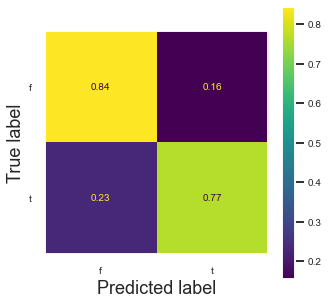

In [69]:
sgd_t = Pipeline([('vec', TfidfVectorizer(ngram_range=(1,2))),
                ('clf', SGDClassifier(class_weight={'f': .45, 't': .55}, random_state=SEED))
            ])

X = cafe_clean['joined_tokens']
y = cafe_clean['t/f']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)

sgd_t.fit(X_train, y_train)

y_pred = sgd_t.predict(X_test)
acc_score = accuracy_score(y_pred, y_test)
print(classification_report(y_pred=y_pred, y_true=y_test, target_names=cafe_clean['t/f'].unique()))

fig, ax = plt.subplots(figsize=(5,5))
plt.rcParams.update({'font.size': 10})
plt.rc('xtick', labelsize=10) 
plt.rc('ytick', labelsize=10) 
plot_confusion_matrix(sgd_t, X_test, y_test, ax=ax, normalize='true')
plt.grid(False);

---

### p/j

In [72]:
cafe_clean['p/j'].value_counts(normalize=True)

p    0.60415
j    0.39585
Name: p/j, dtype: float64

              precision    recall  f1-score   support

           j       0.62      0.58      0.60       863
           p       0.73      0.77      0.75      1306

    accuracy                           0.69      2169
   macro avg       0.68      0.67      0.67      2169
weighted avg       0.69      0.69      0.69      2169



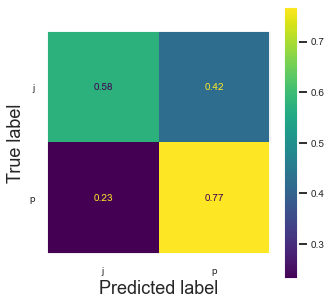

In [73]:
sgd_t = Pipeline([('vec', TfidfVectorizer(ngram_range=(1,2))),
                ('clf', SGDClassifier(class_weight={'p': .40, 'j': .60}, random_state=SEED))
            ])

X = cafe_clean['joined_tokens']
y = cafe_clean['p/j']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)

sgd_t.fit(X_train, y_train)

y_pred = sgd_t.predict(X_test)
acc_score = accuracy_score(y_pred, y_test)
print(classification_report(y_pred=y_pred, y_true=y_test, target_names=cafe_clean['p/j'].unique()))

fig, ax = plt.subplots(figsize=(5,5))
plt.rcParams.update({'font.size': 10})
plt.rc('xtick', labelsize=10) 
plt.rc('ytick', labelsize=10) 
plot_confusion_matrix(sgd_t, X_test, y_test, ax=ax, normalize='true')
plt.grid(False);

---

## Final Model

              precision    recall  f1-score   support

           f       0.80      0.84      0.82      1150
           t       0.81      0.77      0.79      1019

    accuracy                           0.81      2169
   macro avg       0.81      0.81      0.81      2169
weighted avg       0.81      0.81      0.81      2169



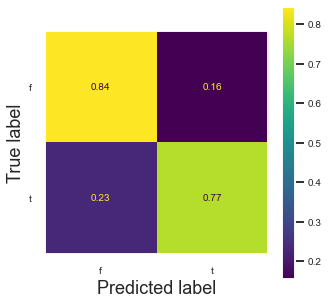

In [75]:
final_model = Pipeline([('vec', TfidfVectorizer(ngram_range=(1,2))),
                ('clf', SGDClassifier(class_weight={'f': .45, 't': .55}, random_state=SEED))
            ])

X = cafe_clean['joined_tokens']
y = cafe_clean['t/f']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)

final_model.fit(X_train, y_train)

y_pred = final_model.predict(X_test)
acc_score = accuracy_score(y_pred, y_test)
print(classification_report(y_pred=y_pred, y_true=y_test, target_names=cafe_clean['t/f'].unique()))

fig, ax = plt.subplots(figsize=(5,5))
plt.rcParams.update({'font.size': 10})
plt.rc('xtick', labelsize=10) 
plt.rc('ytick', labelsize=10) 
plot_confusion_matrix(final_model, X_test, y_test, ax=ax, normalize='true')
plt.grid(False);

In [133]:
f_test_sample = "I'm 38, have no job, no car, live with my brother, I'm a 2/10 physically, obese, I've got 3 kids that I have no involvement with at no choice of my own, I'm disabled, I have no friends, no family other than my brother and the occasional phone call from my mother. I'm a realist, nothing about me is attractive, rather the opposite. I've got ALL the red flags.but still, I appreciate your effort but there is no more a chance for me at love than there would be at winning the lotto."

In [134]:
t_test_sample = "Nature provides exceptions to every rule. But this rule is applied to itself paradoxically. (So there must be some rules without any exception :)"

In [135]:
final_model.predict([f_test_sample])

array(['t'], dtype='<U1')

In [146]:
cafe_clean.columns

Index(['type', 'posts', 'clean_posts', 'post_tokens', 'joined_tokens', 'i/e',
       'n/s', 't/f', 'p/j'],
      dtype='object')

In [152]:
t_fdist = FreqDist(cafe_clean["post_tokens"][cafe_clean["t/f"] == 't'].explode())
f_fdist = FreqDist(cafe_clean["post_tokens"][cafe_clean["t/f"] == 'f'].explode())

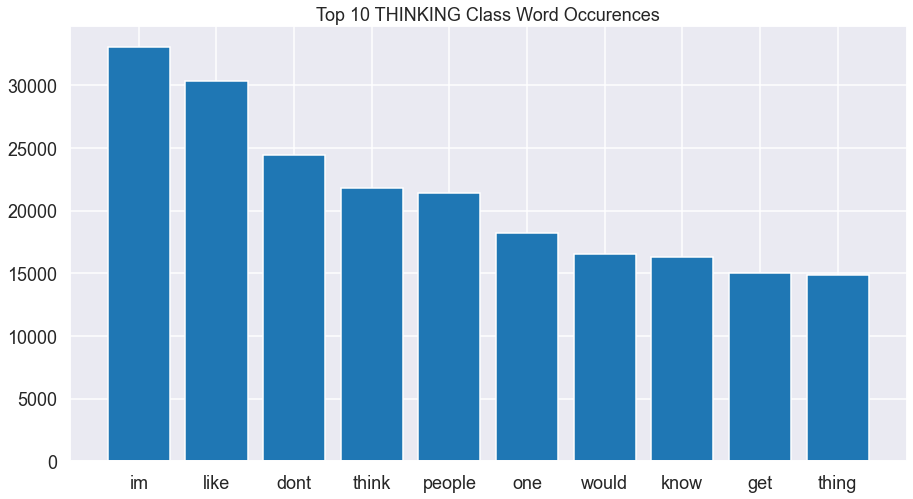

In [149]:
top_ten = list(zip(*t_fdist.most_common(10)))
tokens = top_ten[0]
counts = top_ten[1]

plt.figure(figsize=(15, 8))
plt.rcParams.update({'font.size': 18})
plt.rc('xtick', labelsize=18) 
plt.rc('ytick', labelsize=18) 
plt.bar(tokens, counts)
plt.title('Top 10 THINKING Class Word Occurences');

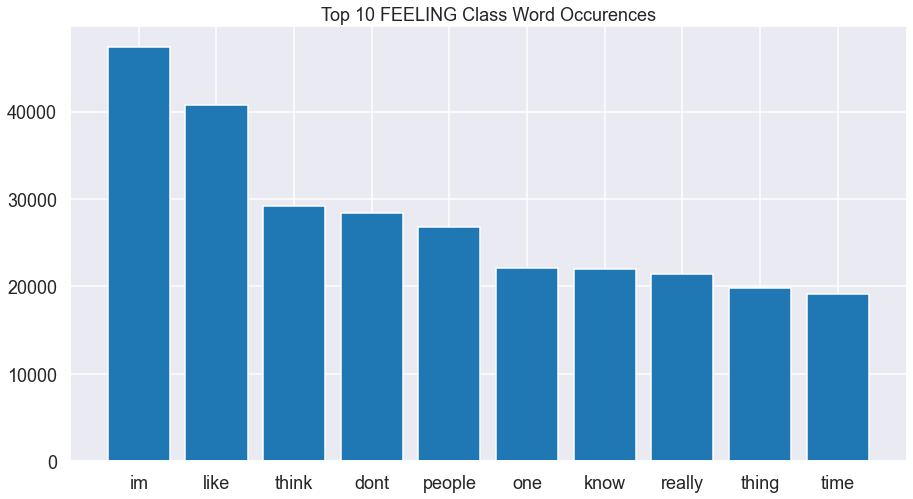

In [151]:
top_ten = list(zip(*f_fdist.most_common(10)))
tokens = top_ten[0]
counts = top_ten[1]

plt.figure(figsize=(15, 8))
plt.rcParams.update({'font.size': 18})
plt.rc('xtick', labelsize=18) 
plt.rc('ytick', labelsize=18) 
plt.bar(tokens, counts)
plt.title('Top 10 FEELING Class Word Occurences');

In [1]:
t_df = cafe_clean[cafe_clean["t/f"] == 't']

cv = CountVectorizer(ngram_range=(2,2))

tf_cv = cv.fit(t_df['joined_tokens'])
tf_cv = cv.transform(t_df['joined_tokens'])

count_values = tf_cv.toarray().sum(axis=0)

vocab = cv.vocabulary_

df_ngram = pd.DataFrame(sorted([(count_values[i], k) for k, i in vocab.items()], reverse=True) \
                        ).rename(columns={0: 'frequency', 1:'bigram'})

plt.figure(figsize=(20, 8))
plt.bar(df_ngram.bigram.iloc[:15], df_ngram.frequency.iloc[:15])

NameError: name 'cafe_clean' is not defined

In [191]:
t_df = cafe_clean[cafe_clean["t/f"] == 'f']

cv = CountVectorizer(ngram_range=(2,2))

tf_cv = cv.fit(t_df['joined_tokens'])
tf_cv = cv.transform(t_df['joined_tokens'])

count_values = tf_cv.toarray().sum(axis=0)

vocab = cv.vocabulary_

df_ngram = pd.DataFrame(sorted([(count_values[i], k) for k, i in vocab.items()], reverse=True) \
                        ).rename(columns={0: 'frequency', 1:'bigram'})

plt.figure(figsize=(20, 8))
plt.bar(df_ngram.bigram.iloc[:15], df_ngram.frequency.iloc[:15])

---

In [ ]:
final_df = pd.read_pickle('./pickle/finalmodeling_df.pkl')

In [ ]:
final_df.token_joined.str.match(regxx).sum()

In [ ]:
final_df['token_joined'] = final_df['token_joined'].apply(replace_mbti)

In [ ]:
final_df = final_df[final_df.token_joined.str.match(regxx) == False]

In [ ]:
final_df = final_df.reset_index()

In [ ]:
final_df

In [ ]:
rm.run(final_df, 'token_joined', bin_targets, baseline_models, models_table, tfidf=False, SEED=234)

In [ ]:
rm.run(final_df, 'token_joined', bin_targets, baseline_models, models_table, tfidf=True, SEED=234)

In [ ]:
print(final_df['i/e'].value_counts(normalize=True))
print(final_df['n/s'].value_counts(normalize=True))
print(final_df['t/f'].value_counts(normalize=True))
print(final_df['p/j'].value_counts(normalize=True))

In [ ]:
rint = np.random.randint(0, len(final_df))

print(rint)
print(final_df['type'].iloc[rint])
final_df['token_joined'].iloc[rint]

## Data and Methods

## Results

## Applications of the Predictive Model

There are numerous applications for using this personality predictive model:

- Customer Segmentation
- Digital Advertising 


## Online Demo

## Recommednations

## Next Steps